In [150]:
# imports
import requests
import pandas as pd
import re
import time
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import lyricsgenius as lg
import matplotlib.pyplot as plt

In [151]:
# api keys
spotify_id = "049441ca05594f60871edeaf3d0370ec"
spotify_secret = "ee5eb1a6d90840638490492be7042358"
lastFM_key = "a623e345cf0922ba10015233327f6f86"
genius_token = "hsV5Dn3hK9DptH26S8SzYKMWUcxGxH4GRQE-z_PTx04WVu4ifdp1Vq5ObINHXFeF"

# roots
spotify_token = "https://accounts.spotify.com/api/token"
spotify_root = "https://api.spotify.com/v1/"
lastFM_root = "https://ws.audioscrobbler.com/2.0/"

In [152]:
#spotify access token
bodyParams = {"grant_type": "client_credentials"} # tells spotify to use client credentials to get the access token
url = spotify_token # stores spotify token request endpoint url
respJSON = requests.post(spotify_token, data=bodyParams, auth =(spotify_id, spotify_secret)).json() 
# sends a post request to spotify for a new access token using secret and id
# converts it to json
headers = {"Authorization":"Bearer "+respJSON["access_token"]} 
# creats an authorization header for spotify api calls
# attaches the access token recieved so spotify can access the data

In [153]:
# spotify top 100 playlist
# unfortunatly spotify dosen't allow you to grab its url from its offical playlists
# which means that the access is restricted and leads to an error 404
# to fix this I decided to use top 100 most streamed songs, thats been last updated on October 24, 2025
# just a small limitation but I believe this is a good fix for it

playlistID = "3zTMBeFDAkUPToFS3flEaz" # (https://open.spotify.com/playlist/3zTMBeFDAkUPToFS3flEaz)
# unique spotify id to pull the playlist
playlistREQUEST = requests.get(spotify_root + f"playlists/{playlistID}/tracks", headers=headers, params={"limit":50}).json()
# sends a request to spotify's api asking for 50 tracks from the specific playlist
tracks = playlistREQUEST["items"] # grabs a list of track data inside the json using "items"
songNAMES = [item["track"]["name"] for item in tracks] # creates a list of song titles from each song in the playlist
artists = [item["track"]["artists"][0]["name"] for item in tracks] # creates a list of artist names, only takes the first artist in each track
trackID = [item["track"]["id"] for item in tracks] # grabs each songs unique spotify song id
spotifyPOP = [item["track"]["popularity"] for item in tracks] # creates a list of each songs popularity score

In [154]:
# using firefox for selenium
options = Options() # creates and "options" object to use firefox settings for selenium
options.add_argument("-headless") # tells firefox to use no visible windows
driver = webdriver.Firefox(options=options) # starts up a new brower using firefox, with selenium

In [155]:
# scraping with selenium for playcounts
driver.implicitly_wait(5) # my selenium kept timing out so I had to look up a solution, this allows it to wait up to 5 seconds before giving an error
playcounts = [] # emtpy list for each play count
for t in trackID: # loops through each spotify song id
    trackURL = f"https://open.spotify.com/track/{t}" # creates spotify webpage link for each song
    try: # catches errors
        driver.get(trackURL) # opens the song page in firefox
        sTAG = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "span[data-testid='playcount']")))
        # waits 10 seconds for the element showing the play count to appear
        playcounts.append(sTAG.text) # saves the play count into text, then into a list
    except TimeoutException: # if the play count dosent load in time
        playcounts.append(None)  # gives none if that happens
    time.sleep(0.5) # waits half a second to load songs so it dosen't overload

driver.quit()  # closes the browser when done

In [156]:
# spotify playcounts text into int
spotify_playcount_int = [] # empty list to store play counts as a number
for pc in playcounts: # loops through each play count that was scraped
    if pc is not None: # checks if its missing
        spotify_playcount_int.append(int(pc.replace(",", ""))) # removes commas, converts the text into an integer, then adds it to the list
    else:
        spotify_playcount_int.append(None) # if the play count is missing adds none

In [157]:
# lastFM playcounts and listeners

lastFM_counts = [] # empty list for lastFM play counts
lastFM_listeners = [] # empty list for total listeners

for i in range(len(songNAMES)): # loops through each song
    song = songNAMES[i] # gets the song title in the current loop
    artist = artists[i] # gets the artist name in the current loop

    songURL = f"{lastFM_root}?method=track.getinfo&artist={artist}&track={song.replace(' ', '+')}&api_key={lastFM_key}&format=json"
     # artist={ARTIST}: tells last.fm to grab the artist
     # track={name.replace(' ', '+')}: replaces the empty space with the title of the song and adds a + so that the API can read it correctly
     # API key to grab the request in json

    response = requests.get(songURL) 
    songDATA = response.json()
    # sends a request to lastFM then turns it into a dictionary 

    if "track" in songDATA and "playcount" in songDATA["track"]: # checks if lastFM returns a play count
        lastFM_counts.append(int(songDATA["track"]["playcount"])) # if it does then converts it into a number and adds to the list
    else:
        lastFM_counts.append(None) # if it dosent returns none

    if "track" in songDATA and "listeners" in songDATA["track"]: # checks if lastFM returns a listener count
        lastFM_listeners.append(int(songDATA["track"]["listeners"])) # if it does then converts it into a number and adds to the list
    else:
        lastFM_listeners.append(None) # if it dosent returns none

In [168]:
# genius pageviews, clean lyrics, clean title, clean artist
genius = lg.Genius(genius_token) # connects to genius api using my api token
genius.remove_section_headers = True # removes labels like verse and chorus when the lyrics are pulled
genius.excluded_terms = ["Remix", "\\(", "- live at", "Remas\\w*"] # tells genius to ignore songs that have remix or live at in their titles


def clean_title(t): # function to clean out the title
    t = t.strip() # removes extra spaces
    t = re.sub(r"\s*\([^)]*\)", "", t) # deletes anything inside the parentheses
    t = re.sub(r"-\s*.*$", "", t) # cuts off the text after a dash
    t = re.sub(r"(feat\.?|ft\.?).*", "", t, flags=re.I) # removes features like feat or ft.
    # flags=re.I is basically just a reg expression thats short for IGNORECASE, without it, it would only match exactly upper or lower case
    t = re.sub(r"\s+", " ", t) # turns multiple spaces into one space
    return t.strip() # returns the final title


def clean_artist(a): # function to clean an artists name
    a = a.strip() # removes extra space
    a = re.sub(r",.*$", "", a) # removes anything after a comma (basically for features)  
    return a # returns the final artist 


def clean_genius_lyrics(song_lyrics): # function to clean the lyrics
    if (song_lyrics.find("Read More\xa0\n") != -1): # removes the read more
        clean = re.sub(r"\d+ Contributor*[\S\s]+Read More\xa0\n", "", song_lyrics) # removes numbers and the word contributor(s) or any characters up to read more then removes it as well
    else:
        clean = re.sub(r"\d+ Contributors*.+Lyrics", "", song_lyrics) # if it cant find it, it removes everything starting with a number and the word contributors, basically cleans out the info at the top
    return clean # returns the clean lyrics

genius_pageviews = [] # empty list for page views

for i in range(len(songNAMES)): # loops through each song in the list
    raw_title = songNAMES[i] # grabs current song name
    raw_artist = artists[i] # grabs current artist name

    t1 = clean_title(raw_title) # cleans the title before giving it to Genius
    a1 = clean_artist(raw_artist) # cleans the artist before giving it to Genius

    s = genius.search_song(t1, a1) # tells genius to search for the song title and artist and store it 

    # fallback: title only
    if s is None:
        print('No results for "' + t1 + '" by ' + a1 + '. Trying title only...') 
        # if it cant find the artist name, only looks for the title
        s = genius.search_song(t1)

    if s is None:
        print('No results found for: "' + t1 + '"') # if nothing comes up it adds none to the list
        genius_pageviews.append(None)
    else:
        stats = s._body.get("stats", {}) # if it is found, pulls from the page view count and saves it
        genius_pageviews.append(stats.get("pageviews"))

    time.sleep(1) # waits one second between requests to avoid timeouts

Searching for "Blinding Lights" by The Weeknd...
Done.
Searching for "Shape of You" by Ed Sheeran...
Done.
Searching for "Someone You Loved" by Lewis Capaldi...
Done.
Searching for "Sunflower" by Post Malone...
Done.
Searching for "Starboy" by The Weeknd...
Done.
Searching for "Dance Monkey" by Tones And I...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "One Dance" by Drake...
Done.
Searching for "I Hope You Hear This and Cry" by Rust and Redemption...
No results found for: 'I Hope You Hear This and Cry Rust and Redemption'
No results for "I Hope You Hear This and Cry" by Rust and Redemption. Trying title only...
Searching for "I Hope You Hear This and Cry"...
No results found for: 'I Hope You Hear This and Cry'
No results found for: "I Hope You Hear This and Cry"
Searching for "STAY" by The Kid LAROI...
Done.
Searching for "Chained" by Olga Wilz...
No results found for: 'Chained Olga Wilz'
No results for "Chained" by Olga Wilz. Trying title only...
Searching 

In [163]:
# artist genre from spotify
# this took a lot of effort to figure out and a lot of research.
# it still dosent fully grab each genre for every song but gives enough for those that dont return none
genre = [] # empty list for each genre

for i in range(len(artists)):  # looping through every artist name
    artistNAME = artists[i].lower().strip() # lowercase and strip for lyric cleaning     
    artistNAME = re.sub(r"\s*\([^)]*\)", "", artistNAME) # removes anything in parenthesis   
    artistNAME = re.sub(r"\s+", " ", artistNAME) # replaces multiple spaces with just a single space            

    params = {"q": artistNAME, "type": "artist", "limit": 1} # creates a search query to look up a specific artist on spotify
    artistSEARCH = requests.get(spotify_root + "search", params=params, headers=headers).json() 
    # sends a search request to spotify's api and returns the results in json
    artistITEMS = [] # empy list for artist results
    if "artists" in artistSEARCH and "items" in artistSEARCH["artists"]: # if the search found artist data
        artistITEMS = artistSEARCH["artists"]["items"] # saves the artist data as a list in artistITEMS

    if len(artistITEMS) == 0: # if no artists were found 
        genre.append(None) # returns none
    else:
        artistID = artistITEMS[0]["id"] # if an artist is found, grabs the spotify id of the first artist
        artistINFO = requests.get(spotify_root + f"artists/{artistID}", headers=headers).json()
        # uses the artist id to send another api call to grab artist info (including the genres they use)
        
        genreLIST = [] # empty list to store the artist genres
        if "genres" in artistINFO: # if an artist info includes a genre
            genreLIST = artistINFO["genres"] # saves them to genreLIST

        if len(genreLIST) == 0: # if an artist dosent include a genre
            genre.append(None) # returns none
        else:
            genre.append(", ".join(genreLIST)) # will return each genre into a single string with commas, adds it to the genre list

In [162]:
# dataframes
df = pd.DataFrame({ # creates a new data fraame using pandas
    "Song":                   songNAMES, # creates a column called song for song names
    "Artist":                 artists, # creates a column called artist for artist in each song
    "SpotifyTrackID":         trackID, # creates a column for each spotify song id
    "SpotifyPopularity":      spotifyPOP, # creates a column for spotify popularity score
    "SpotifyPlaycount":       pd.Series(spotify_playcount_int, dtype="Int64"), # creates a column for spotify playcounts
    # pd.Series(spotify_playcount_int, dtype="Int64" makes sure there arent any errors or missing values
    "LastFMCounts":           lastFM_counts, # creates a column for each playcount in lastFM
    "LastFMListeners":        lastFM_listeners, # creates a column of unique listeners for lastFM
    "GeniusPageViews":        genius_pageviews, # creates a column showing pageview counts from Genius
    "Genre":                  genre # creates a column for genres
})

df.head(50) # prints 50 rows 

,Song,Artist,SpotifyTrackID,SpotifyPopularity,SpotifyPlaycount,LastFMCounts,LastFMListeners,GeniusPageViews,Genre
0,Blinding Lights,The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,89,5092148218,36236274.0,2200565.0,3051149.0,None
1,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,88,4607681546,11218477.0,1248821.0,15614317.0,soft pop
2,Someone You Loved,Lewis Capaldi,7qEHsqek33rTcFNT9PFqLf,86,4099325363,11639396.0,1001356.0,3934216.0,soft pop
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,3KkXRkHbMCARz0aVfEt68P,82,3997166062,24284425.0,1649932.0,3270402.0,None
4,Starboy,The Weeknd,5aAx2yezTd8zXrkmtKl66Z,3,4160746047,30477093.0,2154136.0,9572249.0,None
5,Dance Monkey,Tones And I,2XU0oxnq2qxCpomAAuJY8K,73,3341628090,7207942.0,719762.0,2431877.0,None
6,As It Was,Harry Styles,4Dvkj6JhhA12EX05fT7y2e,87,4086115073,39304485.0,1856464.0,3982594.0,None
7,One Dance,Drake,1xznGGDReH1oQq0xzbwXa3,4,3842116293,19670587.0,1745964.0,6284960.0,rap
8,I Hope You Hear This and Cry,Rust and Redemption,2r6jezRVKJ127ltPq63WlJ,13,1857,1.0,1.0,NaN,None
9,STAY (with Justin Bieber),The Kid LAROI,5PjdY0CKGZdEuoNab3yDmX,8,3699609700,20033695.0,1253466.0,1479041.0,None


In [144]:
# charts

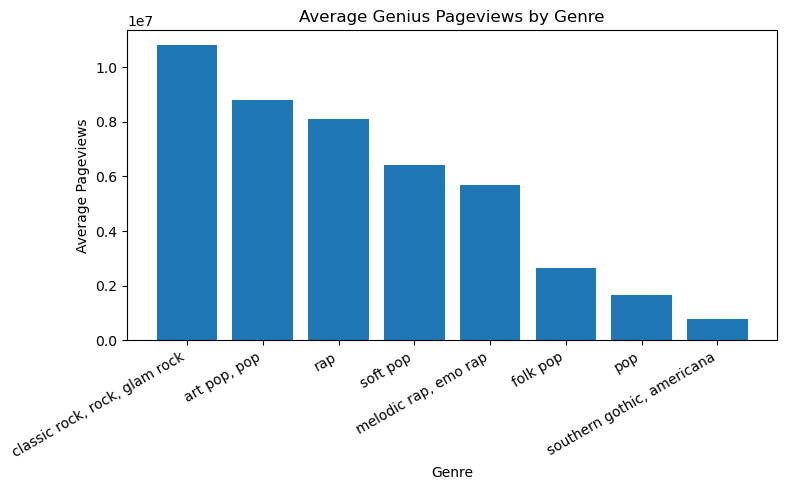

In [164]:
# genius pageviews by genre
genre_views = df.groupby("Genre")["GeniusPageViews"].mean().sort_values(ascending=False)
# groups each song by genre, finds the average number of page views for each genre from high to low
plt.figure(figsize=(8, 5)) # creates a new figure for the chart 8x5
plt.bar(genre_views.index, genre_views.values) # makes it a bar chart
plt.title("Average Genius Pageviews by Genre") # adds a title to make it look nicer
plt.xlabel("Genre") # adds in the x axis and a title (genre)
plt.ylabel("Average Pageviews") # adds the y axis and a title (average pageviews)
plt.xticks(rotation=30, ha="right") # rotates the genre names so they dont overlap (by 30 degrees) to the right
plt.tight_layout() # adjust the layout to make it fit nicer
plt.show() # prints the bar chart

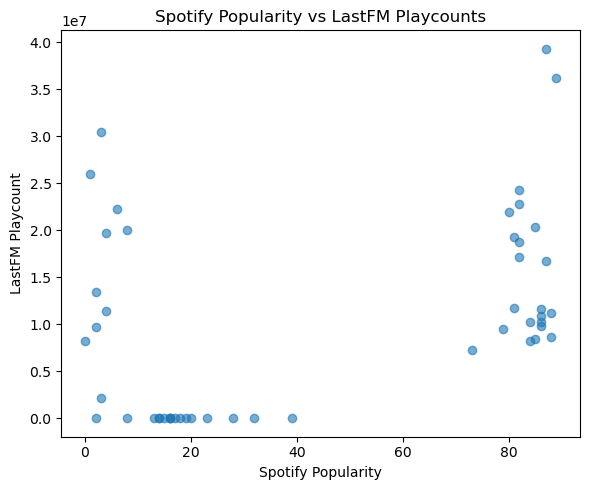

In [170]:
# spotify popularity vs lastFM placyounts
plt.figure(figsize=(6, 5)) # creates a new chart thats 6x5
plt.scatter(df["SpotifyPopularity"], df["LastFMCounts"], alpha=0.6) 
# creates a scatter plot where each dot represents a song
# the x axis shows populairty and y shows playcount
# alpha = 0.6 makes the dots easier to see because there is a decent bit of overlap
plt.title("Spotify Popularity vs LastFM Playcounts") # adds a title
plt.xlabel("Spotify Popularity") # adds in the x axis and a title (spot pop)
plt.ylabel("LastFM Playcount") # adds in the y axis and a title (playcount)
plt.tight_layout() # adjust the layout to make it fit nicer
plt.show() # prints the scatter plot

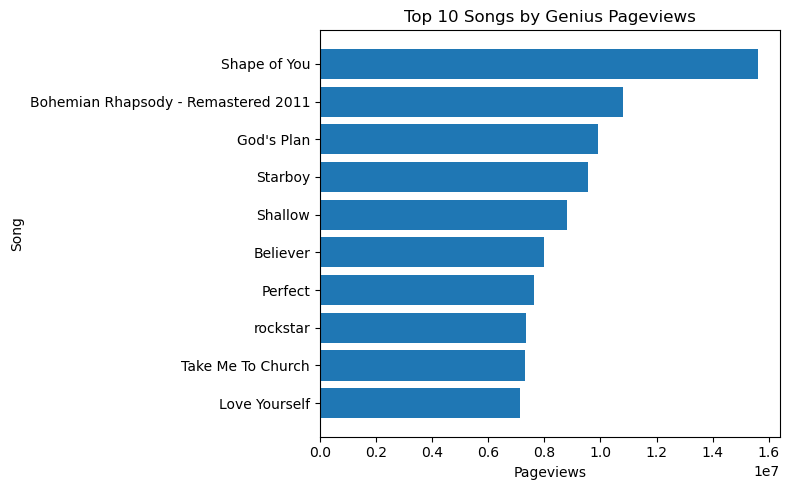

In [166]:
# top 10 songs by genius pageviews
genius10 = df.nlargest(10, "GeniusPageViews") # grabs the top 10 songs in the dataset with highest pageview count
plt.figure(figsize=(8,5)) # creates a new chart 8x5
plt.barh(genius10["Song"], genius10["GeniusPageViews"])
# creates a horizontal bar chart that shows the top 10 songs and pageview counts
plt.title("Top 10 Songs by Genius Pageviews") 
plt.xlabel("Pageviews")
plt.ylabel("Song")
plt.gca().invert_yaxis() # flips the order of the chart so that its greatest to least
plt.tight_layout()
plt.show()

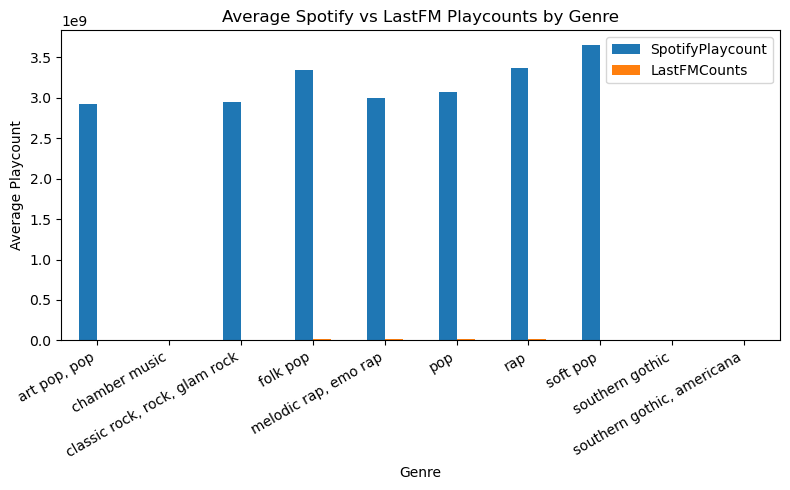

In [167]:
# average spotify vs lastFM sorted by genre
compare_genre = df.groupby("Genre")[["SpotifyPlaycount", "LastFMCounts"]].mean()

compare_genre.plot(kind="bar", figsize=(8,5))
plt.title("Average Spotify vs LastFM Playcounts by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Playcount")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()